# Hypothesis 4

Use your two best models (one for classification and one for regression) from H2 or H3 (it can be Linear model or non-linear model it doesn't matter) with original features set and apply 5 different algorithms for features selection (`feature importance`, `permutation importance`, `L1 regularization`, `Random variable method`, `Recursive feature elimination`). And create models with the same or better quality with smaller amount of input features

## Step by step guide

1. You should select **best regression model** from H2 or H3 with all features and hyperparameters (original model)
2. Fit selected model in this notebook and get train and valid scores and calculate number **input** of features, put this information to the table below (first row in table)
3. Next step, for each feature selection algorithm (`feature importance`, `permutation importance`, `L1 regularization`, `Random variable method`, `Recursive feature elimination`)
    - Select one feature selection algorithm
    - You should start with original model (with all features and original hyperparameters), then apply feature selection method and remove insignificant features
    - Fit model with selected features only (without insignificant features) and get scores (train and valid) and put this information to the table, with number of selected features (see table with all details).
    - Select next features selection method and repeat
4. Select **best classification model** from H2 or H3 with all features and hyperparameters (original model) and repeat steps from 2 to 4
5. Select two best models (one classification and one regression) with **minimum number of features and with best scores (based on table)**
6. **Combine top (selected) features from classification and regression models** into one list
7. Prepare submission files with **top features and prediction columns only** ('__price_predict', '__churn_prob', '__priority')
8. Send this notebook and preprocessed test dataset (with important features only) in a private message in telegram.

In [1]:
import numpy as np
import pandas as pd

# table with metrics for all models
# Example:
# ('For regression model', 'Feature importance', 21, 'metric_for_price', 0.1321, 0.1421),

scoring = pd.DataFrame([
    # Regression
    ('For regression model', 'Original features set', 79, 'metric_for_price', -0.0800, -0.1340),
    ('For regression model', 'Feature importance', 75, 'metric_for_price', -0.0790,  -0.1340),
    ('For regression model', 'Permutation importance', 70, 'metric_for_price', -0.0780, -0.1340),
    ('For regression model', 'L1 regularization', 9, 'metric_for_price', -0.1110, -0.1420),
    ('For regression model', 'Random variable method', 25, 'metric_for_price', -0.0840, -0.1340),
    ('For regression model', 'Recursive feature elimination', 39, 'metric_for_price', -0.0780, -0.1350),
    # Classification
    ('For classification model', 'Original features set', 79, 'metric_for_churn', 0.8930, 0.8560),
    ('For classification model', 'Feature importance', 17, 'metric_for_churn', 0.8910, 0.8580),
    ('For classification model', 'Permutation importance', 6, 'metric_for_churn', 0.8910, 0.8580),
    ('For classification model', 'L1 regularization', 61, 'metric_for_churn', 0.8950, 0.8560),
    ('For classification model', 'Random variable method', 33, 'metric_for_churn', 0.8940, 0.8560),
    ('For classification model', 'Recursive feature elimination', 39 , 'metric_for_churn', 0.8950, 0.8560),
], columns=['Type of model', 'Feature Selection Algorithm', 'number of input features', 'metric_name', 'score_train', 'score_valid'])

scoring

,Type of model,Feature Selection Algorithm,number of input features,metric_name,score_train,score_valid
0,For regression model,Original features set,79,metric_for_price,-0.080,-0.134
1,For regression model,Feature importance,75,metric_for_price,-0.079,-0.134
2,For regression model,Permutation importance,70,metric_for_price,-0.078,-0.134
3,For regression model,L1 regularization,9,metric_for_price,-0.111,-0.142
4,For regression model,Random variable method,25,metric_for_price,-0.084,-0.134
5,For regression model,Recursive feature elimination,39,metric_for_price,-0.078,-0.135
6,For classification model,Original features set,79,metric_for_churn,0.893,0.856
7,For classification model,Feature importance,17,metric_for_churn,0.891,0.858
8,For classification model,Permutation importance,6,metric_for_churn,0.891,0.858
9,For classification model,L1 regularization,61,metric_for_churn,0.895,0.856


In [2]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_percentage_error


def calc_all_metrics(data, max_account=25e3):

    def is_credit_issued(x):
        ratio = x['__price_predict'] / x['__price_doc']
        if x['__priority'] <= 0:
            value = 0.
        elif ratio > 0.9 and ratio < 1.:
            value = x['__price_predict']
        elif ratio >= 1. and ratio < 1.1:
            value = x['__price_doc']
        else:
            value = 0.

        return value

    def calc_profit(x):
        if x['is_credit'] == 0.:
            return 0.
        elif x['__churn'] == 1:
            return - x['debt'] * 2.
        elif x['debt'] < 5:
            return x['debt'] * 0.3
        elif x['debt'] < 9:
            return x['debt'] * 0.4
        elif x['debt'] >= 9:
            return x['debt'] * 0.5

    s = (
        data
        [['__priority', '__churn', '__churn_prob', '__price_doc', '__price_predict']]
        .sort_values('__priority', ascending=False)
        .copy(True)
    )

    s['debt'] = s.apply(is_credit_issued, axis=1)
    s['debt_cum'] = s['debt'].cumsum()
    s['is_credit'] = 0
    s.loc[(s['debt'] > 0) & (s['debt_cum'] <= max_account), 'is_credit'] = 1
    s['profit'] = s.apply(calc_profit, axis=1)

    total_profit = round(s['profit'].sum(), 2)
    good_credits_count = s['is_credit'].sum()
    good_credits_debt = round(s[s['is_credit'] == 1]['debt'].sum(), 2)
    bad_credits_count = s[s['is_credit'] == 1]['__churn'].sum()
    bad_credits_losses = s[(s['is_credit'] == 1) & (s['__churn'] == 1)]['debt'].sum()

    return {
        'total_profit': total_profit,
        '%profit_issued': round(total_profit / good_credits_debt * 100, 1),
        '%issued_loans': round(good_credits_debt / max_account * 100, 2),
        'issued_loans': good_credits_debt,
        'count_good': good_credits_count,
        'count_bad': bad_credits_count,
        '%bad': round(bad_credits_count / (good_credits_count + bad_credits_count) * 100., 1),
        'churn_auc': round(roc_auc_score(y_true=s['__churn'], y_score=s['__churn_prob']), 3),
        'price_nmsle': round(-mean_squared_log_error(y_true=s['__price_doc'], y_pred=s['__price_predict']), 3),
        'price_mape': round(-mean_absolute_percentage_error(y_true=s['__price_doc'], y_pred=s['__price_predict']), 3),
    }


In [3]:
#mount my google drive file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 1000

# Your Name Surname
# !!! should not change in other hypotheses
NAME = "Belton_Manhica"

train_all = pd.read_csv(f"/content/drive/MyDrive/Machine Learning data/1_{NAME}_train.csv")
test = pd.read_csv(f"/content/drive/MyDrive/Machine Learning data/1_{NAME}_test.csv")

TRAIN_SHAPE, TEST_SHAPE = train_all.shape, test.shape
TRAIN_SHAPE, TEST_SHAPE

((20483, 128), (9183, 127))

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_percentage_error


def metric_for_price(y_true, y_pred):
    """ mean_squared_log_error. bigger is better """
    return round(-mean_squared_log_error(y_true=y_true, y_pred=y_pred), 3)


def metric_for_churn(y_true, y_score):
    """ roc_auc_score. bigger is better """
    return round(roc_auc_score(y_true=y_true, y_score=y_score), 3)


RANDOM_STATE = 42
train, valid = train_test_split(train_all, test_size=0.5, stratify=train_all['__churn'], random_state=RANDOM_STATE)
train.shape, valid.shape, test.shape

((10241, 128), (10242, 128), (9183, 127))

In [6]:
list_targets = ['__price_doc', '__churn']

y_train_churn = train['__churn']
y_valid_churn = valid['__churn']
y_train_all_churn = train_all['__churn']

y_train_price = train['__price_doc']
y_valid_price = valid['__price_doc']
y_train_all_price = train_all['__price_doc']

# YOUR WORK STARTS HERE

In [7]:
#select continuous data
continuous_features = list(set(train.dtypes[train.dtypes != "object"].index.tolist())
                    - set(['__churn','__price_doc', 'Unnamed: 0']) )

continuous_features

['total_revolving_bal',
 'metro_km_walk',
 'f_1_office_sqm_5000',
 'f_detention_facility_raion_yes',
 'f_radiation_raion_no',
 'f_thermal_power_plant_raion_no',
 'f_build_year',
 'office_sqm_5000',
 'f_timestamp_target___churn',
 'floor',
 'life_sq',
 'cafe_sum_1500_min_price_avg',
 'f_incineration_raion_no',
 'f_product_type_target___churn',
 'f_timestamp_target___price_doc',
 'f_big_road1_1line_no',
 'f_1_months_on_book',
 'f_marital_status_target___price_doc',
 'f_1_credit_limit',
 'f_build_count_wood',
 'num_room',
 'f_culture_objects_top_25_no',
 'f_state',
 'months_on_book',
 'f_cafe_sum_1500_min_price_avg',
 'build_count_mix',
 'f_1_mkad_km',
 'f_railroad_1line_yes',
 'total_relationship_count',
 'f_income_category_target___price_doc',
 'f_gender_M',
 'f_card_category_target___churn',
 'f_1_sport_count_2000',
 'detention_facility_km',
 'cafe_sum_1000_min_price_avg',
 'f_gender_F',
 'f_1_months_inactive_12_mon',
 'f_ecology_target___churn',
 'f_card_category_target___price_doc',


In [25]:
#select the features to work with
X_train = train[[col for col in continuous_features if col.startswith('f_')]]
X_valid = valid[[col for col in continuous_features if col.startswith('f_')]]

X_train_all = train_all[[col for col in continuous_features if col.startswith('f_')]]
X_test = test[[col for col in continuous_features if col.startswith('f_')]]

In [57]:
#create a list to store the train_all and test data
get_X_y = [
    ('train', X_train, train),
    ('valid', X_valid, valid)
]

#The best regression model: CATBOOST

In [10]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [118]:
from catboost import CatBoostRegressor

#get training data
name, X_, y_ = get_X_y[0]

#build the model
CB_reg = CatBoostRegressor(random_state=47, max_depth = 7, learning_rate = 0.05 )

#fit the model
CB_reg.fit(X_, y_['__price_doc'])

#make predictions
for name, X_, y_ in get_X_y:
  value = CB_reg.predict(X_)
 #convert all negative predictions to zero
  value[value < 0] = 0
    #append the values of the prediction
  y_['__price_predict'] = value

0:	learn: 4.4026740	total: 255ms	remaining: 4m 15s
1:	learn: 4.3117038	total: 283ms	remaining: 2m 20s
2:	learn: 4.2249966	total: 307ms	remaining: 1m 41s
3:	learn: 4.1400740	total: 342ms	remaining: 1m 25s
4:	learn: 4.0607569	total: 384ms	remaining: 1m 16s
5:	learn: 3.9921504	total: 424ms	remaining: 1m 10s
6:	learn: 3.9142762	total: 459ms	remaining: 1m 5s
7:	learn: 3.8493421	total: 507ms	remaining: 1m 2s
8:	learn: 3.7836788	total: 531ms	remaining: 58.5s
9:	learn: 3.7233920	total: 565ms	remaining: 55.9s
10:	learn: 3.6699495	total: 613ms	remaining: 55.1s
11:	learn: 3.6223165	total: 678ms	remaining: 55.9s
12:	learn: 3.5702997	total: 709ms	remaining: 53.8s
13:	learn: 3.5257601	total: 746ms	remaining: 52.6s
14:	learn: 3.4805931	total: 784ms	remaining: 51.5s
15:	learn: 3.4394863	total: 816ms	remaining: 50.2s
16:	learn: 3.4022746	total: 851ms	remaining: 49.2s
17:	learn: 3.3657467	total: 898ms	remaining: 49s
18:	learn: 3.3305565	total: 924ms	remaining: 47.7s
19:	learn: 3.2953455	total: 970ms	rem

In [119]:
for name, X_, y_ in get_X_y:
    score = metric_for_price(y_true = y_['__price_doc'] , y_pred= y_['__price_predict'])
    print(f'{name:10s}: {score:.4f}')

train     : -0.0800
valid     : -0.1340


# Interpretability

**feature importance**

In [ ]:
CB_feature_importances = (pd.Series(CB_reg.feature_importances_, index = X_train.columns.tolist()).sort_values(ascending = False).round(4))
CB_feature_importances

,0
f_1_full_sq,30.8648
f_timestamp_target___price_doc,6.9045
f_1_office_sqm_5000,6.7601
f_metro_km_walk,2.8562
f_1_sport_count_2000,2.7574
f_1_trc_count_2000,2.6747
f_1_cafe_count_1000_price_1000,2.4072
f_1_detention_facility_km,2.3924
f_build_year,2.2313
f_railroad_station_walk_km,1.9467


<Axes: >

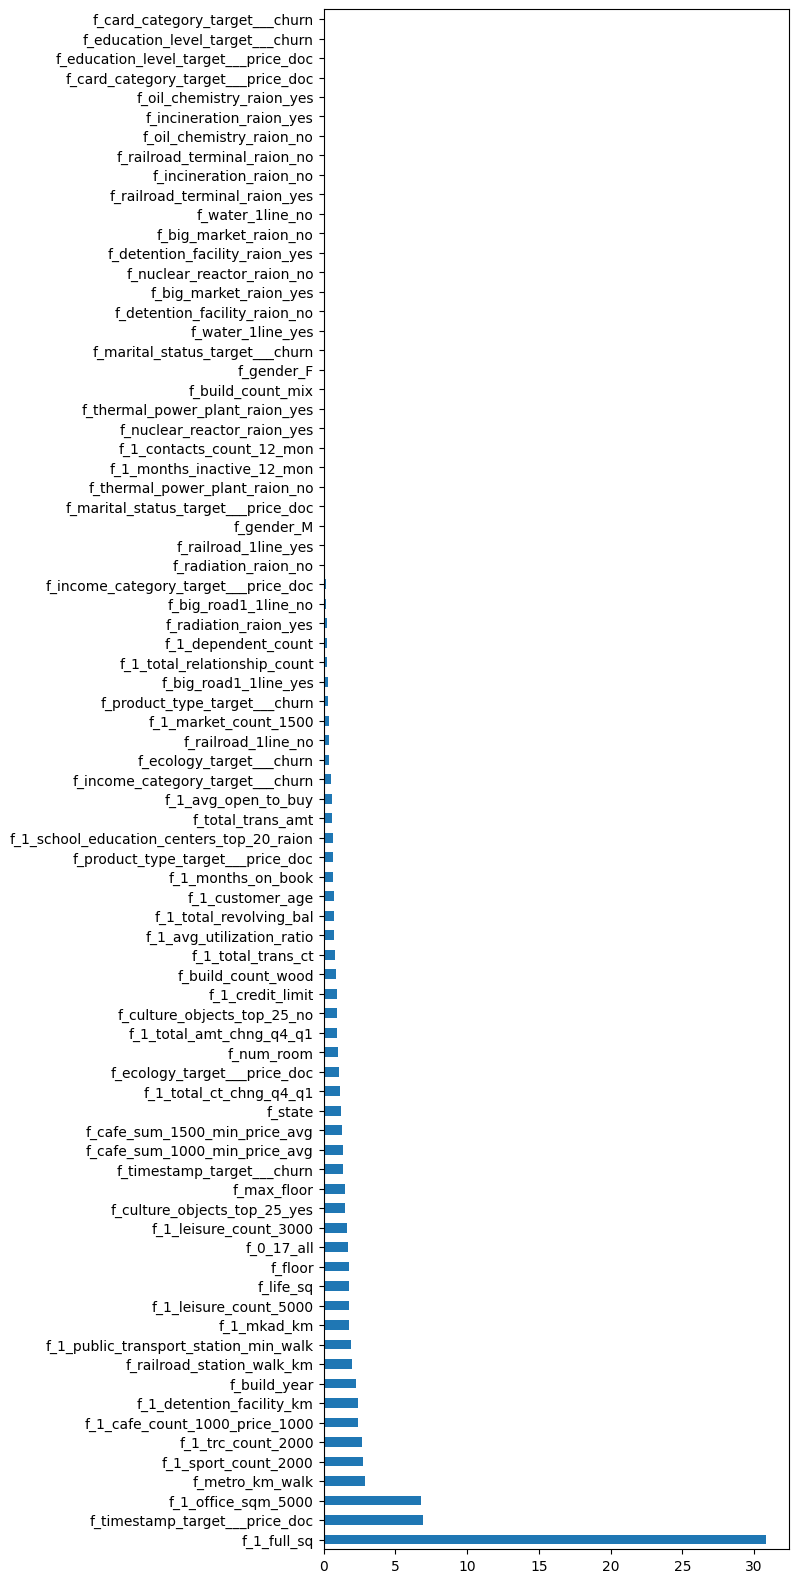

In [ ]:
CB_feature_importances.plot(kind = 'barh', figsize=(6, 20))

In [ ]:
#select important features and exclude meaningless ones
threshold = 0.0027
selected_features_FI = CB_feature_importances[CB_feature_importances > threshold]
selected_features_FI= selected_features_FI.index

In [ ]:
#get the number of features selected
len(selected_features_FI)

75

In [ ]:
#fit the model with feature importances

#get training data
name, X_, y_ = get_X_y[0]

#build the model
CB_reg_FI = CatBoostRegressor(random_state=47, max_depth = 7, learning_rate = 0.05 )

#fit the model
CB_reg_FI.fit(X_[selected_features_FI], y_['__price_doc'])

#make predictions
for name, X_, y_ in get_X_y:
  value_FI = CB_reg_FI.predict(X_[selected_features_FI])
 #convert all negative predictions to zero
  value_FI[value_FI < 0] = 0
    #append the values of the prediction
  y_['__price_predict_FI'] = value_FI



0:	learn: 4.4047813	total: 23.8ms	remaining: 23.8s
1:	learn: 4.3097606	total: 40.7ms	remaining: 20.3s
2:	learn: 4.2282809	total: 57.4ms	remaining: 19.1s
3:	learn: 4.1445079	total: 73.3ms	remaining: 18.3s
4:	learn: 4.0561574	total: 90.6ms	remaining: 18s
5:	learn: 3.9807564	total: 107ms	remaining: 17.7s
6:	learn: 3.9131953	total: 122ms	remaining: 17.4s
7:	learn: 3.8513012	total: 138ms	remaining: 17.1s
8:	learn: 3.7856858	total: 155ms	remaining: 17s
9:	learn: 3.7293628	total: 170ms	remaining: 16.8s
10:	learn: 3.6763219	total: 187ms	remaining: 16.8s
11:	learn: 3.6306867	total: 202ms	remaining: 16.7s
12:	learn: 3.5789729	total: 219ms	remaining: 16.6s
13:	learn: 3.5309399	total: 240ms	remaining: 16.9s
14:	learn: 3.4868753	total: 259ms	remaining: 17s
15:	learn: 3.4512011	total: 275ms	remaining: 16.9s
16:	learn: 3.4107249	total: 294ms	remaining: 17s
17:	learn: 3.3734102	total: 310ms	remaining: 16.9s
18:	learn: 3.3366417	total: 327ms	remaining: 16.9s
19:	learn: 3.2990568	total: 343ms	remaining:

In [ ]:
for name, X_, y_ in get_X_y:
    score = metric_for_price(y_true = y_['__price_doc'] , y_pred= y_['__price_predict_FI'])
    print(f'{name:10s}: {score:.4f}')

train     : -0.0790
valid     : -0.1340


**permutation importance**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

#select the train dataset
name, X_, y_ = get_X_y[0]

#Permutation importance calculation
result = permutation_importance(CB_reg, X_, y_['__price_doc'], n_repeats= 10,  random_state=42, scoring='neg_mean_squared_error' )

#Get the indexes for the mean of the results of the features
sorted_idx = result.importances_mean.argsort()

#get the columns of all features
feature_names = X_train_all.columns[sorted_idx].tolist()

#get the importance score for each festure
feature_importances_P = result.importances[sorted_idx].T

In [ ]:
feature_PI = pd.Series(result.importances_mean, index = feature_names)
feature_PI.sort_values(ascending = False)

,0
f_max_floor,14.630246
f_life_sq,2.255380
f_1_total_ct_chng_q4_q1,1.702038
f_big_road1_1line_no,0.538735
f_product_type_target___price_doc,0.530186
f_big_market_raion_yes,0.472566
f_1_total_relationship_count,0.407588
f_cafe_sum_1000_min_price_avg,0.395479
f_1_contacts_count_12_mon,0.393440
f_floor,0.366120


<ipython-input-21-ed2e440b8126>:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(feature_importances_P, vert=False, labels = feature_names)


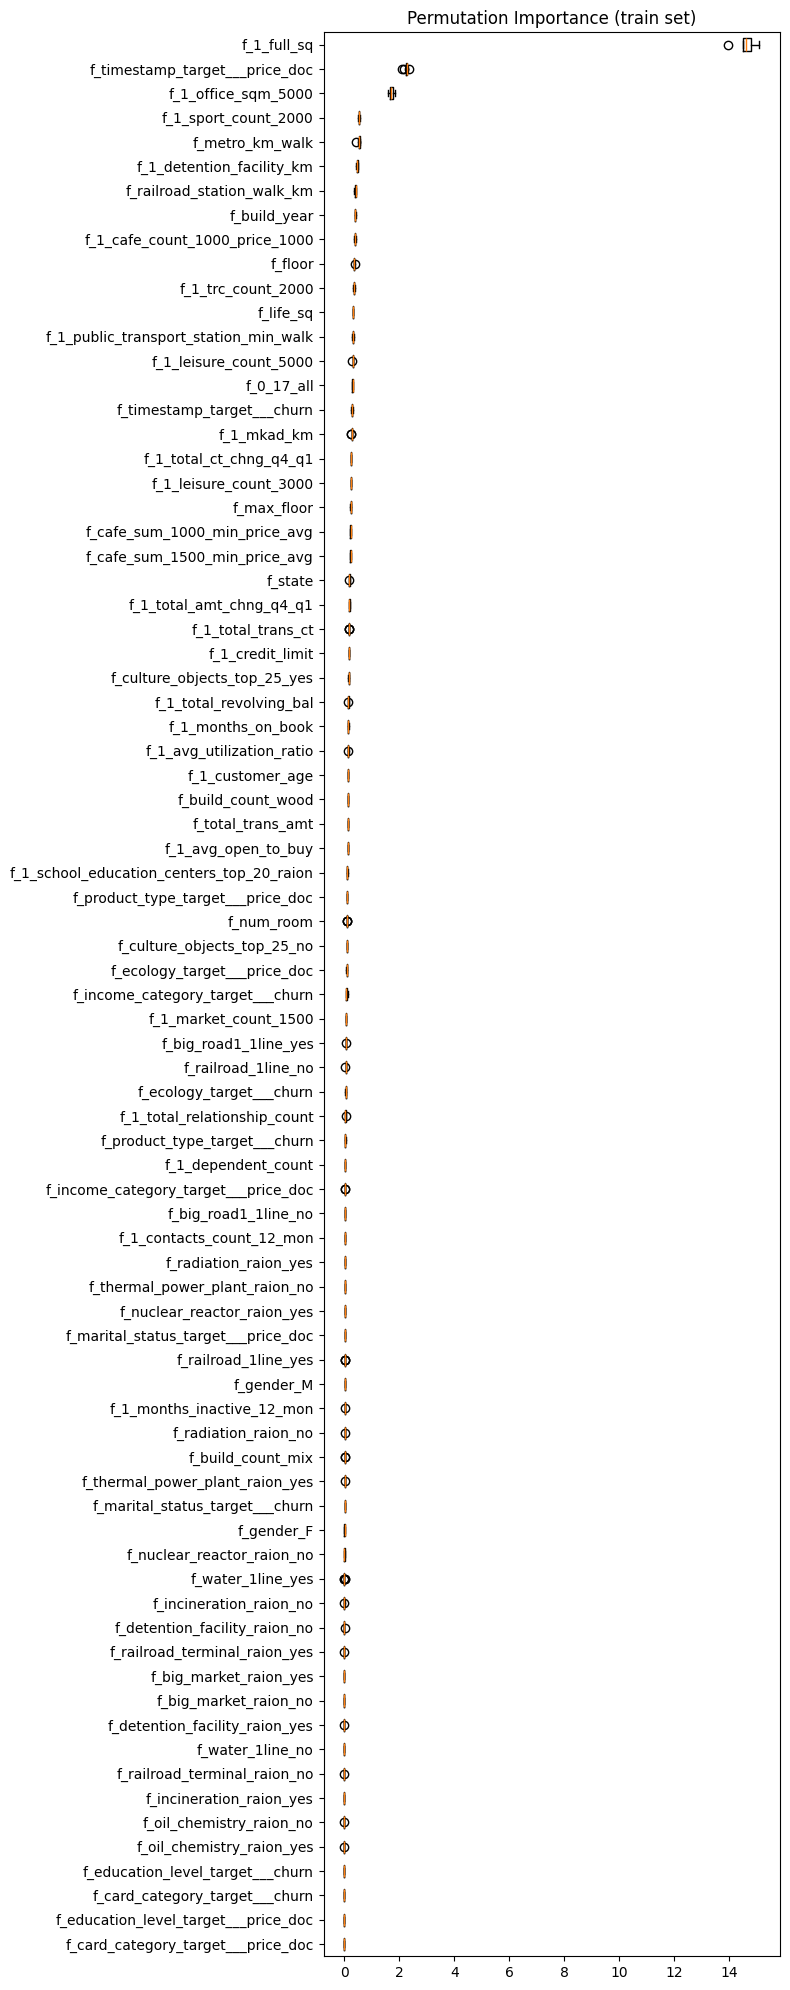

In [ ]:
fig, ax = plt.subplots(figsize = (8, 20))
ax.boxplot(feature_importances_P, vert=False, labels = feature_names)
ax.set_title(f"Permutation Importance ({name} set)")
fig.tight_layout()
plt.show()

In [ ]:
#select important features and exclude meaningless ones
threshold = 0.0027
selected_features_PI = feature_PI[feature_PI > threshold]
selected_features_PI= selected_features_PI.index

In [ ]:
#get the number of features selected
len(selected_features_PI)

70

In [ ]:
#fit the model with permutation_importance features

#get training data
name, X_, y_ = get_X_y[0]

#build the model
CB_reg_PI = CatBoostRegressor(random_state=47, max_depth = 7, learning_rate = 0.05 )

#fit the model
CB_reg_PI.fit(X_[selected_features_PI], y_['__price_doc'])

#make predictions
for name, X_, y_ in get_X_y:
  value_PI = CB_reg_PI.predict(X_[selected_features_PI])
 #convert all negative predictions to zero
  value_PI[value_PI < 0] = 0
    #append the values of the prediction
  y_['__price_predict_PI'] = value_PI



0:	learn: 4.3994347	total: 20.7ms	remaining: 20.7s
1:	learn: 4.3058220	total: 35.5ms	remaining: 17.7s
2:	learn: 4.2113896	total: 52.1ms	remaining: 17.3s
3:	learn: 4.1245302	total: 66.3ms	remaining: 16.5s
4:	learn: 4.0507097	total: 80.4ms	remaining: 16s
5:	learn: 3.9770135	total: 95ms	remaining: 15.7s
6:	learn: 3.9071128	total: 109ms	remaining: 15.5s
7:	learn: 3.8375761	total: 124ms	remaining: 15.4s
8:	learn: 3.7773907	total: 140ms	remaining: 15.4s
9:	learn: 3.7141325	total: 155ms	remaining: 15.3s
10:	learn: 3.6589280	total: 170ms	remaining: 15.2s
11:	learn: 3.6058834	total: 184ms	remaining: 15.2s
12:	learn: 3.5536582	total: 200ms	remaining: 15.2s
13:	learn: 3.5109066	total: 215ms	remaining: 15.2s
14:	learn: 3.4681623	total: 234ms	remaining: 15.4s
15:	learn: 3.4281011	total: 249ms	remaining: 15.3s
16:	learn: 3.3899985	total: 265ms	remaining: 15.3s
17:	learn: 3.3553904	total: 280ms	remaining: 15.3s
18:	learn: 3.3235452	total: 294ms	remaining: 15.2s
19:	learn: 3.2964580	total: 311ms	remai

In [ ]:
for name, X_, y_ in get_X_y:
    score = metric_for_price(y_true = y_['__price_doc'] , y_pred= y_['__price_predict_PI'])
    print(f'{name:10s}: {score:.4f}')

train     : -0.0780
valid     : -0.1340


**L1 regularization**

In [ ]:
from sklearn.linear_model import Lasso

name, X_, y_ = get_X_y[0]

#fit the data
lasso_reg = Lasso(alpha = 0.5)
lasso_reg.fit(X_, y_['__price_doc'])


Lasso(alpha=0.5)

In [ ]:
#get feature importances for Lasso
feature_imp = lasso_reg.coef_
feature_imp_lasso = pd.Series(feature_imp, index = X_train.columns.tolist())
feature_imp_lasso = feature_imp_lasso[feature_imp_lasso.abs()> 0.0001].sort_values(ascending= False)
feature_imp_lasso

,0
f_1_full_sq,1.844671
f_ecology_target___price_doc,0.172093
f_timestamp_target___price_doc,0.158857
f_1_cafe_count_1000_price_1000,0.138117
f_1_sport_count_2000,0.091288
f_1_leisure_count_5000,0.068638
f_1_office_sqm_5000,0.056294
f_1_leisure_count_3000,0.030988
f_ecology_target___churn,-0.029268


In [ ]:
#get the number od features selected
len(feature_imp_lasso)

9

<Axes: >

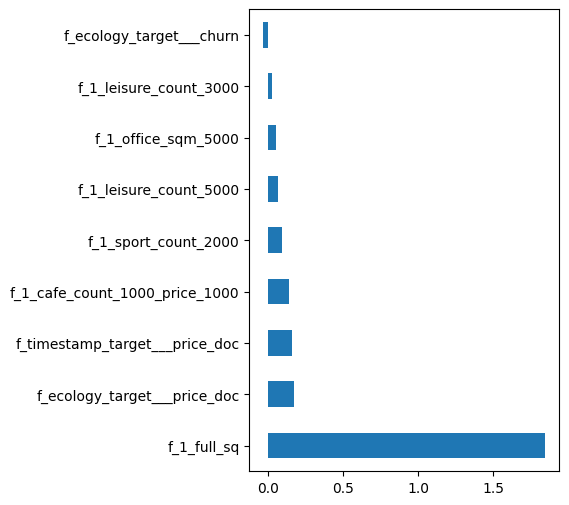

In [ ]:
feature_imp_lasso.plot(kind ='barh', figsize = (4, 6))

In [ ]:
#fit the model with lasso feature importance

#get training data
name, X_, y_ = get_X_y[0]

#build the model
CB_reg_LI = CatBoostRegressor(random_state=47, max_depth = 7, learning_rate = 0.05 )

#fit the model
CB_reg_LI.fit(X_[feature_imp_lasso.index], y_['__price_doc'])

#make predictions
for name, X_, y_ in get_X_y:
  value_LI = CB_reg_LI.predict(X_[feature_imp_lasso.index])
 #convert all negative predictions to zero
  value_LI[value_LI < 0] = 0
    #add the values of the prediction
  y_['__price_predict_LI'] = value_LI

0:	learn: 4.3989045	total: 9.62ms	remaining: 9.61s
1:	learn: 4.3023535	total: 14.4ms	remaining: 7.19s
2:	learn: 4.2098614	total: 19.3ms	remaining: 6.42s
3:	learn: 4.1242562	total: 24.4ms	remaining: 6.07s
4:	learn: 4.0395509	total: 28.1ms	remaining: 5.58s
5:	learn: 3.9678775	total: 31.9ms	remaining: 5.29s
6:	learn: 3.8997007	total: 36.3ms	remaining: 5.15s
7:	learn: 3.8318201	total: 40ms	remaining: 4.96s
8:	learn: 3.7681308	total: 43.9ms	remaining: 4.83s
9:	learn: 3.7091069	total: 47.6ms	remaining: 4.71s
10:	learn: 3.6562612	total: 51.3ms	remaining: 4.61s
11:	learn: 3.6048500	total: 55ms	remaining: 4.52s
12:	learn: 3.5578574	total: 58.5ms	remaining: 4.44s
13:	learn: 3.5171044	total: 62.2ms	remaining: 4.38s
14:	learn: 3.4799768	total: 66.1ms	remaining: 4.34s
15:	learn: 3.4441362	total: 70.1ms	remaining: 4.31s
16:	learn: 3.4087120	total: 73.7ms	remaining: 4.26s
17:	learn: 3.3763850	total: 82.1ms	remaining: 4.48s
18:	learn: 3.3459282	total: 86.1ms	remaining: 4.44s
19:	learn: 3.3164140	total

In [ ]:
for name, X_, y_ in get_X_y:
    score = metric_for_price(y_true = y_['__price_doc'] , y_pred= y_['__price_predict_LI'])
    print(f'{name:10s}: {score:.4f}')

train     : -0.1110
valid     : -0.1420


Random variable method

In [120]:

name , X_, y_ = get_X_y[0]

#copy the train set
X__ = X_train.copy(True)

#create a random feature and add it tho the dataset
X__["random"] = np.random.uniform(0,1, len(X__))

#train the model with the random values
CB_reg_RV = CatBoostRegressor(random_state = 47, max_depth = 7, learning_rate = 0.05)

#fit the module
CB_reg_RV.fit(X__, y_['__price_doc'])



0:	learn: 4.3988600	total: 21.7ms	remaining: 21.7s
1:	learn: 4.3038061	total: 38.3ms	remaining: 19.1s
2:	learn: 4.2075285	total: 56.7ms	remaining: 18.9s
3:	learn: 4.1285798	total: 72.8ms	remaining: 18.1s
4:	learn: 4.0518396	total: 87.9ms	remaining: 17.5s
5:	learn: 3.9763102	total: 103ms	remaining: 17.1s
6:	learn: 3.9094086	total: 118ms	remaining: 16.8s
7:	learn: 3.8451065	total: 134ms	remaining: 16.6s
8:	learn: 3.7781663	total: 149ms	remaining: 16.4s
9:	learn: 3.7161233	total: 165ms	remaining: 16.4s
10:	learn: 3.6583794	total: 181ms	remaining: 16.3s
11:	learn: 3.6073213	total: 196ms	remaining: 16.2s
12:	learn: 3.5568091	total: 211ms	remaining: 16.1s
13:	learn: 3.5121851	total: 231ms	remaining: 16.3s
14:	learn: 3.4699402	total: 248ms	remaining: 16.3s
15:	learn: 3.4291659	total: 263ms	remaining: 16.2s
16:	learn: 3.3937005	total: 278ms	remaining: 16.1s
17:	learn: 3.3576412	total: 293ms	remaining: 16s
18:	learn: 3.3265651	total: 308ms	remaining: 15.9s
19:	learn: 3.2943926	total: 323ms	rema

In [129]:
#get the importance of features
df = pd.DataFrame({"features": X__.columns, "importance": CB_reg_RV.feature_importances_})
importance_RV = df[df["features"] == "random"]["importance"].iloc[0]

#select features with importance greater than "random" importance
selected_features_RV = df[df["importance"] > importance_RV]["features"].tolist()

#see the names of the features

selected_features_RV

['f_1_full_sq',
 'f_1_mkad_km',
 'f_1_public_transport_station_min_walk',
 'f_1_leisure_count_3000',
 'f_1_total_ct_chng_q4_q1',
 'f_cafe_sum_1000_min_price_avg',
 'f_max_floor',
 'f_timestamp_target___price_doc',
 'f_build_year',
 'f_culture_objects_top_25_no',
 'f_state',
 'f_timestamp_target___churn',
 'f_floor',
 'f_life_sq',
 'f_1_office_sqm_5000',
 'f_1_leisure_count_5000',
 'f_1_sport_count_2000',
 'f_railroad_station_walk_km',
 'f_1_detention_facility_km',
 'f_1_trc_count_2000',
 'f_1_cafe_count_1000_price_1000',
 'f_metro_km_walk',
 'f_0_17_all',
 'f_cafe_sum_1500_min_price_avg']

In [142]:
#create a dataframe to better sort them in descending order
imp_sorted = df[df["importance"] > importance_RV]["importance"].sort_values(ascending=False).tolist()
list_it = pd.DataFrame(imp_sorted  , index = selected_features_RV)
list_it

,0
f_1_full_sq,30.517180
f_1_mkad_km,6.732339
f_1_public_transport_station_min_walk,5.523403
f_1_leisure_count_3000,3.195709
f_1_total_ct_chng_q4_q1,2.745550
f_cafe_sum_1000_min_price_avg,2.671896
f_max_floor,2.592230
f_timestamp_target___price_doc,2.515546
f_build_year,2.169662
f_culture_objects_top_25_no,2.158669


In [ ]:
#get the number of features selected
len(selected_features_RV)

25

In [ ]:
#train a model with the selected features

name, X_, y_ = get_X_y[0]

CB_reg_RV.fit(X_[selected_features_RV], y_['__price_doc'])

#make predictions
for name, X_, y_ in get_X_y:
  value_RV = CB_reg_RV.predict(X_[selected_features_RV])
  #make negative values zero
  value_RV[value_RV < 0] = 0
  #add the prediction to the dataset
  y_["__price_predict_RV"] = value_RV


0:	learn: 4.3905449	total: 13.6ms	remaining: 13.6s
1:	learn: 4.2975356	total: 23.7ms	remaining: 11.8s
2:	learn: 4.2087397	total: 33.5ms	remaining: 11.1s
3:	learn: 4.1258661	total: 44.5ms	remaining: 11.1s
4:	learn: 4.0441657	total: 54.8ms	remaining: 10.9s
5:	learn: 3.9623118	total: 64.6ms	remaining: 10.7s
6:	learn: 3.8901636	total: 75.1ms	remaining: 10.7s
7:	learn: 3.8227949	total: 86.3ms	remaining: 10.7s
8:	learn: 3.7632353	total: 96.9ms	remaining: 10.7s
9:	learn: 3.7011966	total: 107ms	remaining: 10.6s
10:	learn: 3.6499089	total: 117ms	remaining: 10.5s
11:	learn: 3.5964129	total: 126ms	remaining: 10.4s
12:	learn: 3.5507919	total: 136ms	remaining: 10.3s
13:	learn: 3.5046157	total: 146ms	remaining: 10.3s
14:	learn: 3.4591973	total: 156ms	remaining: 10.2s
15:	learn: 3.4213012	total: 166ms	remaining: 10.2s
16:	learn: 3.3804710	total: 175ms	remaining: 10.1s
17:	learn: 3.3413450	total: 184ms	remaining: 10s
18:	learn: 3.3081947	total: 194ms	remaining: 10s
19:	learn: 3.2734563	total: 204ms	re

In [ ]:
for name, X_, y_ in get_X_y:
  score = metric_for_price(y_true = y_['__price_doc'], y_pred = y_['__price_predict_RV'])
  print(f"{name:10s}: {score:.4f}")

train     : -0.0840
valid     : -0.1340


Recursive feature elimination

In [ ]:
from sklearn.feature_selection import RFE

name, X_, y_ = get_X_y[0]

#creat the model
CB_reg_RF = CatBoostRegressor(random_state= 47, max_depth=7, learning_rate= 0.05)

#run the RFE on the untrained model
rec_f = RFE (
    estimator = CB_reg_RF,
    step =1
)

#fir the RFE
rec_f.fit(X_, y_['__price_doc'])

Streaming output truncated to the last 5000 lines.
0:	learn: 4.3995196	total: 16.7ms	remaining: 16.7s
1:	learn: 4.3101734	total: 30ms	remaining: 15s
2:	learn: 4.2199642	total: 45.8ms	remaining: 15.2s
3:	learn: 4.1397851	total: 60.1ms	remaining: 15s
4:	learn: 4.0560311	total: 73.3ms	remaining: 14.6s
5:	learn: 3.9839971	total: 86.4ms	remaining: 14.3s
6:	learn: 3.9176134	total: 105ms	remaining: 14.9s
7:	learn: 3.8465842	total: 118ms	remaining: 14.6s
8:	learn: 3.7807428	total: 132ms	remaining: 14.6s
9:	learn: 3.7272325	total: 145ms	remaining: 14.4s
10:	learn: 3.6725325	total: 158ms	remaining: 14.2s
11:	learn: 3.6186109	total: 172ms	remaining: 14.1s
12:	learn: 3.5726157	total: 185ms	remaining: 14s
13:	learn: 3.5284817	total: 199ms	remaining: 14s
14:	learn: 3.4887103	total: 213ms	remaining: 14s
15:	learn: 3.4426312	total: 226ms	remaining: 13.9s
16:	learn: 3.4048978	total: 239ms	remaining: 13.8s
17:	learn: 3.3661823	total: 254ms	remaining: 13.8s
18:	learn: 3.3294555	total: 268ms	remaining: 13

RFE(estimator=<catboost.core.CatBoostRegressor object at 0x790cdc0ede10>)

In [ ]:
df_RF = pd.DataFrame({"features": X_.columns, "importance":rec_f.ranking_ })
selected_features_RF = df_RF[df_RF["importance"] == 1 ]["features"].tolist()
selected_features_RF

['f_1_total_revolving_bal',
 'f_1_trc_count_2000',
 'f_1_customer_age',
 'f_num_room',
 'f_state',
 'f_build_count_wood',
 'f_1_detention_facility_km',
 'f_1_leisure_count_3000',
 'f_total_trans_amt',
 'f_0_17_all',
 'f_cafe_sum_1000_min_price_avg',
 'f_1_total_amt_chng_q4_q1',
 'f_1_credit_limit',
 'f_culture_objects_top_25_yes',
 'f_1_cafe_count_1000_price_1000',
 'f_1_sport_count_2000',
 'f_railroad_station_walk_km',
 'f_1_public_transport_station_min_walk',
 'f_life_sq',
 'f_1_total_trans_ct',
 'f_max_floor',
 'f_ecology_target___price_doc',
 'f_metro_km_walk',
 'f_timestamp_target___churn',
 'f_1_leisure_count_5000',
 'f_1_avg_open_to_buy',
 'f_cafe_sum_1500_min_price_avg',
 'f_build_year',
 'f_1_full_sq',
 'f_1_total_ct_chng_q4_q1',
 'f_1_office_sqm_5000',
 'f_1_months_on_book',
 'f_culture_objects_top_25_no',
 'f_1_avg_utilization_ratio',
 'f_1_mkad_km',
 'f_timestamp_target___price_doc',
 'f_floor',
 'f_product_type_target___price_doc',
 'f_income_category_target___churn']

In [ ]:
#get the number of features
len(selected_features_RF)

39

In [ ]:
#fit the model with selected features for RFE

name, X_, y_ = get_X_y[0]
CB_reg_RF.fit(X_[selected_features_RF], y_['__price_doc'])

for name, X_, y_ in get_X_y:
  value_RF = CB_reg_RF.predict(X_[selected_features_RF])

  value_RF[value_RF < 0] = 0
  y_['__price_predict_RF'] = value_RF

0:	learn: 4.3957119	total: 51ms	remaining: 51s
1:	learn: 4.3001271	total: 146ms	remaining: 1m 12s
2:	learn: 4.2086907	total: 258ms	remaining: 1m 25s
3:	learn: 4.1287097	total: 362ms	remaining: 1m 30s
4:	learn: 4.0494169	total: 545ms	remaining: 1m 48s
5:	learn: 3.9752839	total: 650ms	remaining: 1m 47s
6:	learn: 3.8980605	total: 734ms	remaining: 1m 44s
7:	learn: 3.8318393	total: 827ms	remaining: 1m 42s
8:	learn: 3.7737835	total: 916ms	remaining: 1m 40s
9:	learn: 3.7167857	total: 1s	remaining: 1m 39s
10:	learn: 3.6602932	total: 1.1s	remaining: 1m 39s
11:	learn: 3.6139399	total: 1.21s	remaining: 1m 39s
12:	learn: 3.5643290	total: 1.29s	remaining: 1m 38s
13:	learn: 3.5172140	total: 1.41s	remaining: 1m 39s
14:	learn: 3.4748602	total: 1.49s	remaining: 1m 38s
15:	learn: 3.4355753	total: 1.65s	remaining: 1m 41s
16:	learn: 3.3969654	total: 1.75s	remaining: 1m 41s
17:	learn: 3.3638059	total: 1.86s	remaining: 1m 41s
18:	learn: 3.3291639	total: 1.92s	remaining: 1m 39s
19:	learn: 3.2972828	total: 1.

In [ ]:
for name, X_, y_ in get_X_y:
  score = metric_for_price(y_true = y_['__price_doc'], y_pred = y_['__price_predict_RF'])
  print(f"{name:10s}: {score:.4f}")

train     : -0.0780
valid     : -0.1350


**Best Classification model: XGBOOST**

In [58]:
from xgboost import XGBClassifier

#select the training data
name, X_, y_ = get_X_y[0]

#create a range for the hyperparameters max_depth and other

#build the forest
XGB_class_best = XGBClassifier(random_state= 47, max_depth=3, learning_rate = 0.1 )

#fit the model
XGB_class_best.fit(X_, y_['__churn'])

#make predictions
for name, X_, y_ in get_X_y:
  prob = XGB_class_best.predict_proba(X_)
  y_['__churn_prob'] = prob[:,1]

  y_['__churn_threshold'] = 0.5
  y_['__churn_pred'] = (y_['__churn_prob'] > y_['__churn_threshold']).astype(int)

In [59]:
for name , X_, y_ in get_X_y:
  score = metric_for_churn(y_true = y_['__churn'], y_score= y_['__churn_pred'])
  print(f"{name:10s}: {score:.4f}")

train     : 0.8930
valid     : 0.8560


Feature importance

In [60]:
feature_imp_cl = (pd.Series(XGB_class_best.feature_importances_,index =X_train.columns.tolist() ).sort_values(ascending=False).round(4))
feature_imp_cl

,0
f_1_contacts_count_12_mon,0.4524
f_1_months_inactive_12_mon,0.0574
f_1_total_ct_chng_q4_q1,0.0530
f_1_total_relationship_count,0.0451
f_1_total_trans_ct,0.0401
f_timestamp_target___churn,0.0288
f_total_trans_amt,0.0254
f_1_total_revolving_bal,0.0229
f_1_avg_open_to_buy,0.0193
f_1_avg_utilization_ratio,0.0183


In [115]:
#select important features
selec_fectures_FI = feature_imp_cl[feature_imp_cl>0.01]
selec_fectures_FI.sort_values(ascending=False)

,0
f_1_contacts_count_12_mon,0.4524
f_1_months_inactive_12_mon,0.0574
f_1_total_ct_chng_q4_q1,0.0530
f_1_total_relationship_count,0.0451
f_1_total_trans_ct,0.0401
f_timestamp_target___churn,0.0288
f_total_trans_amt,0.0254
f_1_total_revolving_bal,0.0229
f_1_avg_open_to_buy,0.0193
f_1_avg_utilization_ratio,0.0183


In [62]:
#count the number of features
len(selec_fectures_FI)

17

In [63]:
#fit the model with selected features

name, X_, y_ = get_X_y[0]

XGB_class_best.fit(X_[selec_fectures_FI.index], y_['__churn'])

#make predictions
for name, X_, y_ in get_X_y:
  prob_FI = XGB_class_best.predict_proba(X_[selec_fectures_FI.index])
  y_['__churn_prob'] = prob_FI[:,1]
  y_['__churn_pred'] = (y_['__churn_prob']> y_['__churn_threshold']).astype(int)

  score_FI = metric_for_churn(y_true= y_['__churn'], y_score= y_['__churn_pred'])
  print(f"{name:10s}: {score_FI:.4f}")



train     : 0.8910
valid     : 0.8580


Permutation importance

In [64]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

#select train data
name, X_, y_ = get_X_y[0]

#prepare the model
XGB_class = XGBClassifier(random_state= 47, max_depth=3, learning_rate = 0.1 ).fit(X_,y_['__churn'])

#fit permutation importance to untrained data
result = permutation_importance(XGB_class, X_, y_['__churn'],n_repeats= 10, random_state=42, scoring='neg_mean_squared_error')

#Get indexes for the mean of the results for each feature
sorted_idx = result.importances_mean.argsort()

#get the columns for all features
features_PI = X_train.columns[sorted_idx].tolist()

#get the importance scores for each feature
feature_imp_PI = result.importances[sorted_idx].T


In [65]:
feature_imp_PI = result.importances[sorted_idx].T
feature_imp_PI.shape

(10, 79)

In [66]:
featurePI = pd.Series(result.importances_mean, index = features_PI)
featurePI.sort_values(ascending=False)

,0
f_radiation_raion_yes,0.070901
f_cafe_sum_1500_min_price_avg,0.030065
f_water_1line_no,0.026511
f_1_trc_count_2000,0.020301
f_num_room,0.020047
f_floor,0.011600
f_railroad_terminal_raion_no,0.007177
f_gender_F,0.005917
f_1_market_count_1500,0.003662
f_railroad_1line_no,0.003105


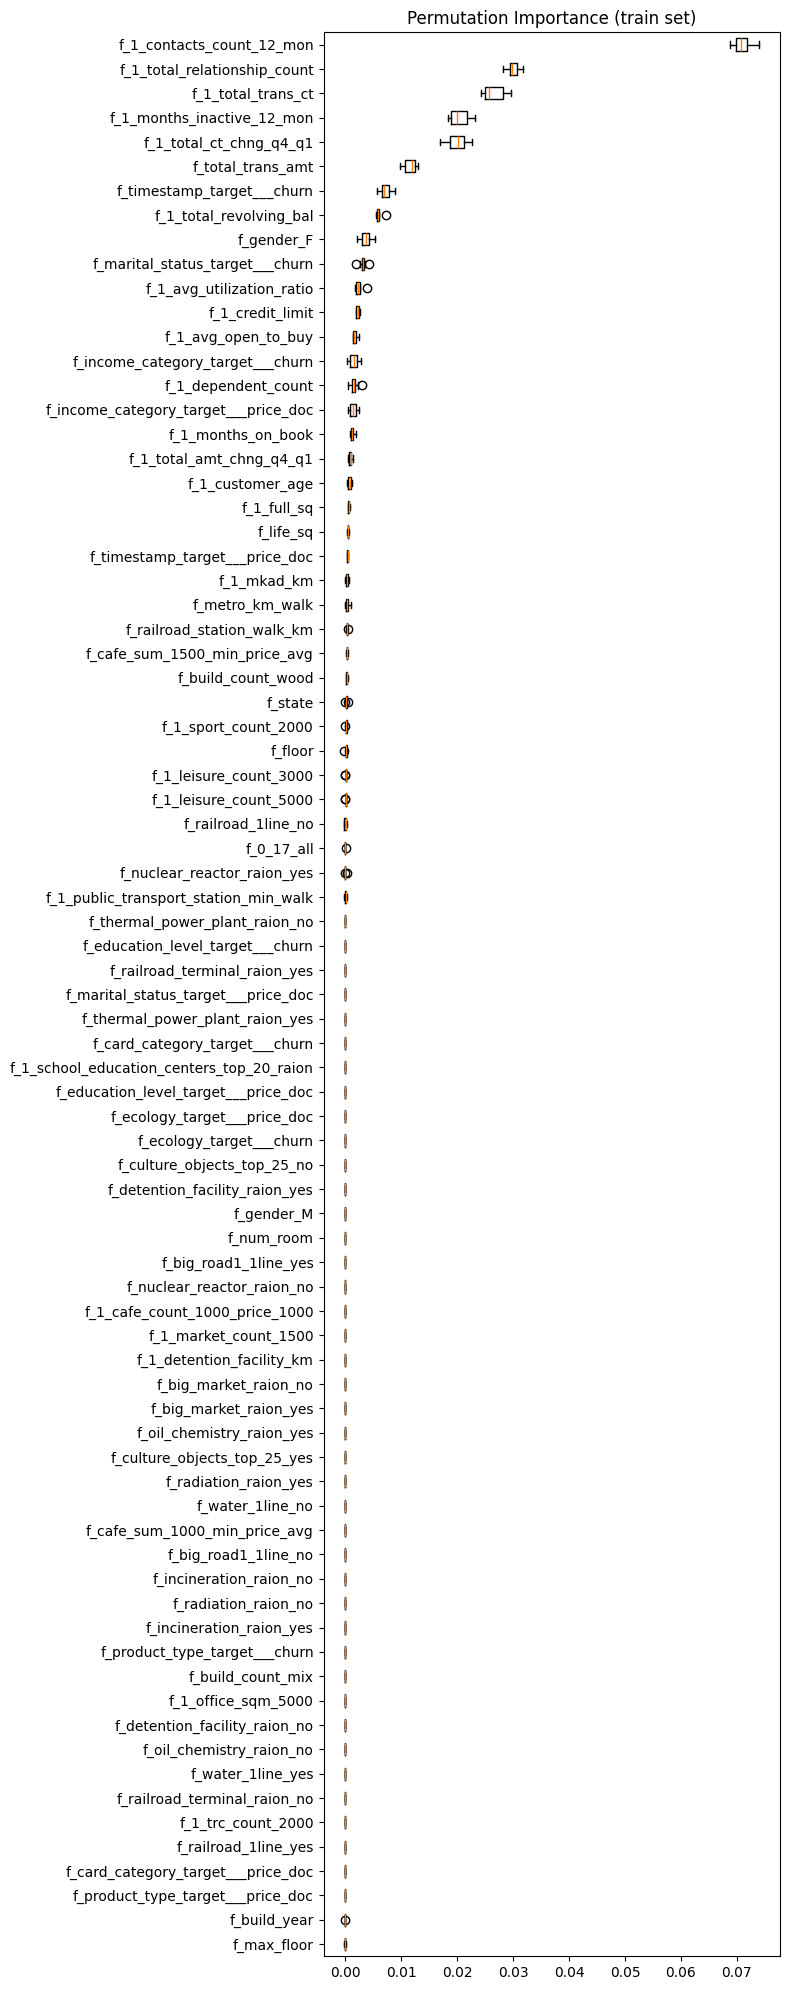

In [ ]:
fig, ax = plt.subplots(figsize = (8, 20))
ax.boxplot(feature_imp_PI, vert =False, tick_labels = features_PI)
ax.set_title(f'Permutation Importance ({name} set)')
fig.tight_layout()
plt.show()

In [ ]:
#select important features
selec_fectures_PI = featurePI[featurePI > 0.01]
selec_feature_PI = selec_fectures_FI.index
selec_fectures_PI.sort_values(ascending=False)

,0
f_total_trans_amt,0.070901
f_ecology_target___churn,0.030065
f_marital_status_target___churn,0.026511
f_nuclear_reactor_raion_no,0.020301
f_water_1line_yes,0.020047
f_incineration_raion_yes,0.011600


In [ ]:
len(selec_fectures_PI)

6

In [ ]:
#fit a model with selected features

name, X_, y_ = get_X_y[0]

#fit the model
XGB_class_PI_ = XGB_class_PI.fit(X_[selec_feature_PI], y_['__churn'])

#make predictions
for name,X_, y_ in get_X_y:
  value_PI_ = XGB_class_PI_.predict_proba(X_[selec_feature_PI])
  value_PI_[value_PI_<0] = 0
  y_['__churn_prob_PI'] =  value_PI_[:,1]

  y_['__churn_pred_PI'] = y_['__churn_prob_PI'] > y_['__churn_threshold']

  score_PI = metric_for_churn(y_true= y_['__churn'], y_score=y_['__churn_pred_PI'])
  print(f'{name:10s}: {score_PI:.4f}')

train     : 0.8910
valid     : 0.8580


Lasso

In [13]:
from sklearn.linear_model import LogisticRegression

#select the train dataset
name, X_, y_ = get_X_y[0]

#define the model and fit it
log_reg = LogisticRegression( penalty = 'l1', solver = 'liblinear', random_state = 0, C = 0.5)
log_reg.fit(X_, y_['__churn'])

for name, X_, y_ in get_X_y:
    pred_lasso = log_reg.predict(X_)
    pred_lasso[pred_lasso < 0] = 0
    y_['__churn_prob_lasso'] = pred_lasso

    score_lasso = metric_for_churn(y_true = y_['__churn'], y_score= y_['__churn_prob_lasso'])
    print(f'{name:10s}: {score_lasso:.4f}')


train     : 0.8530
valid     : 0.8420


In [43]:
coeficients = log_reg.coef_.tolist()

lasso_coeficients  = []

for i in coeficients[0]:

  lasso_coeficients.append(i)

lasso_coeficients


[0.01334648048067394,
 -0.03230842200382228,
 -0.1920075634450596,
 0.05937062416257948,
 0.0,
 0.0,
 2.1217217285381844,
 0.04858533790574248,
 -0.30743532615730124,
 0.0,
 0.0,
 0.2741820414408813,
 0.0005729458513675386,
 0.0,
 -0.6604875034349236,
 0.0,
 0.0,
 0.002150428843396448,
 -0.17332372700140825,
 0.0,
 -0.13951598896733614,
 -1.024147038186719,
 -0.060606739787236,
 0.006783481064547113,
 -0.07052179198156526,
 -0.0764569268391313,
 0.014709434917423408,
 0.04733299168916339,
 0.08008386914852096,
 -0.16367818011360258,
 0.0,
 -0.11105415866356722,
 -0.0008337606517910965,
 -0.18067159918874529,
 0.0,
 -0.030000177146374932,
 0.0,
 1.6738766718400273,
 0.011740931165332294,
 0.4536848736584075,
 -0.12361219828757959,
 0.047877282763314565,
 -0.0009298668840240848,
 0.0,
 0.0,
 -0.7202156862047238,
 0.005333476311300936,
 -0.24656771866042515,
 -0.018390799988465628,
 -0.40139452780788565,
 0.0,
 0.00813863355889699,
 0.1135638163712051,
 -0.413712486280491,
 -0.01695276451

In [46]:
#select important features
features_lasso = pd.Series(lasso_coeficients,  index = X_train.columns.tolist())
features_lasso.sort_values(ascending=False)

,0
f_1_contacts_count_12_mon,2.121722
f_1_months_inactive_12_mon,1.673877
f_timestamp_target___churn,0.453685
f_income_category_target___price_doc,0.274182
f_1_avg_open_to_buy,0.184924
f_1_dependent_count,0.161901
f_card_category_target___price_doc,0.113564
f_timestamp_target___price_doc,0.080084
f_1_full_sq,0.059371
f_1_mkad_km,0.048585


In [56]:
selec_features_L1 = features_lasso[features_lasso != 0]
selec_features_L1.index
len(selec_features_L1.index)

61

In [69]:
#fit a model with selected features

name,X_, y_ = get_X_y[0]

XGB_class_L1 = XGB_class.fit(X_[selec_features_L1.index], y_['__churn'])

for name, X_, y_ in get_X_y:
  value_L1 = XGB_class_L1.predict(X_[selec_features_L1.index])
  y_['__churn_pred_L1'] = value_L1

  score_L1 = metric_for_churn(y_true= y_['__churn'], y_score= y_['__churn_pred_L1'] )
  print(f"{name:10s} : {score_L1:.4f}")




train      : 0.8950
valid      : 0.8560


Random Variable

In [73]:
name, X_, y_ = get_X_y[0]

_X_ = X_train.copy(True)

#create a random feature and add it tho the dataset
_X_['random'] = np.random.uniform(0,1,len(_X_))

#fit the model to the XGB_class model created

XGB_class_RV = XGB_class.fit(_X_, y_['__churn'])

In [91]:
df1 = pd.DataFrame({'features': _X_.columns, 'importance': XGB_class_RV.feature_importances_})
importance__RV = df1[df1['features'] == 'random']['importance'].iloc[0]
importance__RV

np.float32(0.0044220425)

In [94]:
selec_feature_RV = df1[df1['importance']> 0.0044220425]['features'].tolist()
selec_feature_RV

['f_1_full_sq',
 'f_nuclear_reactor_raion_no',
 'f_1_contacts_count_12_mon',
 'f_1_mkad_km',
 'f_railroad_1line_yes',
 'f_income_category_target___price_doc',
 'f_1_total_trans_ct',
 'f_1_public_transport_station_min_walk',
 'f_1_total_ct_chng_q4_q1',
 'f_1_customer_age',
 'f_max_floor',
 'f_marital_status_target___churn',
 'f_timestamp_target___price_doc',
 'f_1_total_amt_chng_q4_q1',
 'f_build_year',
 'f_gender_F',
 'f_state',
 'f_1_months_inactive_12_mon',
 'f_income_category_target___churn',
 'f_timestamp_target___churn',
 'f_1_months_on_book',
 'f_floor',
 'f_life_sq',
 'f_total_trans_amt',
 'f_1_total_relationship_count',
 'f_1_sport_count_2000',
 'f_1_dependent_count',
 'f_1_trc_count_2000',
 'f_1_credit_limit',
 'f_1_total_revolving_bal',
 'f_metro_km_walk',
 'f_1_avg_open_to_buy',
 'f_1_avg_utilization_ratio']

In [98]:
len(selec_feature_RV)

33

In [97]:
#fit a model with selected features for RV

name, X_, y_ = get_X_y[0]

XGB_class_RV_ = XGB_class.fit(X_[selec_feature_RV], y_['__churn'])

for name, X_, y_ in get_X_y:
  value_RV_ = XGB_class_RV_.predict(X_[selec_feature_RV])
  y_['__churn_pred_RV'] = value_RV_
  score_RV = metric_for_churn(y_true=y_['__churn'], y_score=y_['__churn_pred_RV'])
  print(f'{name:10s}: {score_RV:.4f}')


train     : 0.8940
valid     : 0.8560


Recursive feature elimination

In [99]:
from sklearn.feature_selection import RFE

name, X_, y_ = get_X_y[0]

#fit the RFE model
rec_f1 = RFE(
    estimator = XGB_class,
    step =1
).fit(X_, y_['__churn'])



In [111]:
df2 = pd.DataFrame({'Features': X_train.columns, 'ranking': rec_f1.ranking_})
selec_feature_RFE = df2[df2['ranking']==1]["Features"].tolist()
selec_feature_RFE

['f_1_full_sq',
 'f_nuclear_reactor_raion_no',
 'f_1_contacts_count_12_mon',
 'f_1_mkad_km',
 'f_railroad_1line_yes',
 'f_radiation_raion_yes',
 'f_income_category_target___price_doc',
 'f_1_total_trans_ct',
 'f_1_public_transport_station_min_walk',
 'f_1_leisure_count_3000',
 'f_1_total_ct_chng_q4_q1',
 'f_1_customer_age',
 'f_max_floor',
 'f_marital_status_target___churn',
 'f_timestamp_target___price_doc',
 'f_1_total_amt_chng_q4_q1',
 'f_build_year',
 'f_culture_objects_top_25_no',
 'f_gender_F',
 'f_state',
 'f_1_months_inactive_12_mon',
 'f_income_category_target___churn',
 'f_timestamp_target___churn',
 'f_1_months_on_book',
 'f_floor',
 'f_life_sq',
 'f_total_trans_amt',
 'f_1_leisure_count_5000',
 'f_1_total_relationship_count',
 'f_1_sport_count_2000',
 'f_railroad_station_walk_km',
 'f_build_count_wood',
 'f_1_dependent_count',
 'f_1_credit_limit',
 'f_1_total_revolving_bal',
 'f_metro_km_walk',
 'f_cafe_sum_1500_min_price_avg',
 'f_1_avg_open_to_buy',
 'f_1_avg_utilization_

In [113]:
#get the number of features selected
len(selec_feature_RFE)

39

In [112]:
#fit a model with selected features for RFE
name, X_, y_ = get_X_y[0]

XGB_class_RFE = XGB_class.fit(X_[selec_feature_RFE], y_['__churn'])

#make predictions and get the scores
for name, X_, y_ in get_X_y:
  value_RFE = XGB_class_RFE.predict(X_[selec_feature_RFE])
  y_['__churn_pred_RFE'] = value_RFE
  score_RFE = metric_for_churn(y_true = y_['__churn'], y_score= y_['__churn_pred_RFE'])
  print(f'{name:10s}: {score_RFE:.4f}')

train     : 0.8950
valid     : 0.8560


In [37]:
#Top features for regression (Random variable method)

list_1 = ['f_1_full_sq',
'f_1_mkad_km',
'f_1_public_transport_station_min_walk',
'f_1_leisure_count_3000',
'f_1_total_ct_chng_q4_q1',
'f_cafe_sum_1000_min_price_avg',
'f_max_floor',
'f_timestamp_target___price_doc',
'f_build_year',
'f_culture_objects_top_25_no',
'f_state',
'f_life_sq',
'f_1_office_sqm_5000',
'f_1_leisure_count_5000' ,
'f_1_sport_count_2000'  ,
'f_railroad_station_walk_km' ,
'f_1_detention_facility_km' ,
'f_1_trc_count_2000' ,
'f_1_cafe_count_1000_price_1000' ,
'f_metro_km_walk' ,
'f_0_17_all' ,
'f_cafe_sum_1500_min_price_avg']

In [38]:
#Top features for classification (Feature Importance)

list_2 = ['f_1_contacts_count_12_mon',
'f_1_months_inactive_12_mon' ,
'f_1_total_ct_chng_q4_q1' ,
'f_1_total_relationship_count' ,
'f_1_total_trans_ct' ,
'f_timestamp_target___churn'  ,
'f_total_trans_amt' ,
'f_1_total_revolving_bal' ,
'f_1_avg_open_to_buy',
'f_1_avg_utilization_ratio' ,
'f_marital_status_target___churn' ,
'f_income_category_target___churn'  ,
'f_gender_F'  ,
'f_1_credit_limit'  ,
'f_1_dependent_count' ,
'f_1_total_amt_chng_q4_q1'  ,
'f_1_customer_age'  ]

### Please select top_features variable (with best features based on two models)

In [39]:
# List of TOP features based on two models (regression and classification)
# example: top_features = ['max_floor']
top_features = list_1+list_2
# remove duplicated features if exists
top_features = sorted(list(set(top_features)))
top_features

['f_0_17_all',
 'f_1_avg_open_to_buy',
 'f_1_avg_utilization_ratio',
 'f_1_cafe_count_1000_price_1000',
 'f_1_contacts_count_12_mon',
 'f_1_credit_limit',
 'f_1_customer_age',
 'f_1_dependent_count',
 'f_1_detention_facility_km',
 'f_1_full_sq',
 'f_1_leisure_count_3000',
 'f_1_leisure_count_5000',
 'f_1_mkad_km',
 'f_1_months_inactive_12_mon',
 'f_1_office_sqm_5000',
 'f_1_public_transport_station_min_walk',
 'f_1_sport_count_2000',
 'f_1_total_amt_chng_q4_q1',
 'f_1_total_ct_chng_q4_q1',
 'f_1_total_relationship_count',
 'f_1_total_revolving_bal',
 'f_1_total_trans_ct',
 'f_1_trc_count_2000',
 'f_build_year',
 'f_cafe_sum_1000_min_price_avg',
 'f_cafe_sum_1500_min_price_avg',
 'f_culture_objects_top_25_no',
 'f_gender_F',
 'f_income_category_target___churn',
 'f_life_sq',
 'f_marital_status_target___churn',
 'f_max_floor',
 'f_metro_km_walk',
 'f_railroad_station_walk_km',
 'f_state',
 'f_timestamp_target___churn',
 'f_timestamp_target___price_doc',
 'f_total_trans_amt']

In [41]:
top_features in train_all.columns.tolist()

False

In [58]:
#create a list to store the train_all and test data
get_X_y_test = [
    ('train_all', X_train_all, train_all),
    ('test', X_test, test),
    ('train', X_train, train),
    ('valid', X_valid, valid)
]

The best model for regression

In [59]:
from catboost import CatBoostRegressor

#train a model with the selected features
name, X_, y_ = get_X_y_test[0]

CB_reg_top = CatBoostRegressor(random_state=47, max_depth = 7, learning_rate = 0.05 )

CB_reg_top.fit(X_[top_features], y_['__price_doc'])

#make predictions
for name, X_, y_ in get_X_y_test:
  value_top = CB_reg_top.predict(X_[top_features])
  #make negative values zero
  value_top[value_top < 0] = 0
  #add the prediction to the dataset
  y_['__price_predict'] = value_top

0:	learn: 4.4179945	total: 20.4ms	remaining: 20.4s
1:	learn: 4.3125445	total: 35ms	remaining: 17.5s
2:	learn: 4.2172673	total: 49.8ms	remaining: 16.6s
3:	learn: 4.1263290	total: 66.2ms	remaining: 16.5s
4:	learn: 4.0457236	total: 82.4ms	remaining: 16.4s
5:	learn: 3.9643815	total: 97.7ms	remaining: 16.2s
6:	learn: 3.8927962	total: 113ms	remaining: 16.1s
7:	learn: 3.8241967	total: 128ms	remaining: 15.9s
8:	learn: 3.7573412	total: 143ms	remaining: 15.7s
9:	learn: 3.6961502	total: 157ms	remaining: 15.5s
10:	learn: 3.6375199	total: 171ms	remaining: 15.4s
11:	learn: 3.5827986	total: 189ms	remaining: 15.5s
12:	learn: 3.5291800	total: 203ms	remaining: 15.4s
13:	learn: 3.4779951	total: 217ms	remaining: 15.3s
14:	learn: 3.4350404	total: 237ms	remaining: 15.6s
15:	learn: 3.3941873	total: 254ms	remaining: 15.6s
16:	learn: 3.3517970	total: 269ms	remaining: 15.6s
17:	learn: 3.3153370	total: 285ms	remaining: 15.5s
18:	learn: 3.2790257	total: 300ms	remaining: 15.5s
19:	learn: 3.2464289	total: 315ms	rem

Best model for classification

In [60]:
from xgboost import XGBClassifier

name, X_, y_ = get_X_y_test[0]

#fit the model with selected features

XGB_class_best = XGBClassifier(random_state= 47, max_depth=3, learning_rate = 0.1 )


XGB_class_best.fit(X_[top_features], y_['__churn'])

#make predictions
for name, X_, y_ in get_X_y_test:
  prob_top = XGB_class_best.predict_proba(X_[top_features])
  y_['__churn_prob'] = prob_top[:,1]
  y_['__churn_threshold'] = 0.5
  y_['__churn_pred'] = (y_['__churn_prob']> y_['__churn_threshold']).astype(int)


### Please update the algorithm (see details in Baseline.ipynb)

In [ ]:
def alg1(x,y):
    """
    Algorithm version 1
    """
    return x['__price_predict']

# column __price_predict must be in train and test dataset
train_all['__priority'] = train_all.apply(alg1, axis=1)
train['__priority'] = train.apply(alg1, axis=1)
valid['__priority'] = valid.apply(alg1, axis=1)
test['__priority'] = test.apply(alg1, axis=1)

# Calculate key product and models metrics

In [62]:
calc_all_metrics(train)

{'total_profit': np.float64(899.7),
 '%profit_issued': np.float64(3.6),
 '%issued_loans': np.float64(99.98),
 'issued_loans': np.float64(24995.77),
 'count_good': np.int64(2793),
 'count_bad': np.int64(469),
 '%bad': np.float64(14.4),
 'churn_auc': np.float64(0.98),
 'price_nmsle': -0.101,
 'price_mape': -0.375}

In [63]:
calc_all_metrics(valid)

{'total_profit': np.float64(1479.81),
 '%profit_issued': np.float64(5.9),
 '%issued_loans': np.float64(99.98),
 'issued_loans': np.float64(24996.08),
 'count_good': np.int64(2749),
 'count_bad': np.int64(437),
 '%bad': np.float64(13.7),
 'churn_auc': np.float64(0.979),
 'price_nmsle': -0.099,
 'price_mape': -0.373}

# YOUR WORK IS DONE (Create submission)

In [64]:
metric_for_churn(y_train_all_churn, train_all['__churn_prob'])

np.float64(0.979)

In [65]:
metric_for_price(y_train_all_price, train_all['__price_predict'])

-0.1

In [67]:
# this columns must be in dataset
prediction_columns = ['__price_predict', '__churn_prob', '__priority']

if train_all.shape[0] != TRAIN_SHAPE[0]:
    raise ValueError(f'Incorrect train file shape. Original {TRAIN_SHAPE[0]}. {train_all.shape[0]} are given')

for col in prediction_columns + top_features:
    if col not in train_all.columns.tolist():
        raise ValueError(f"{col} does not exist in train dataset")

# select top_features and predition columns only
train_all_top = train_all[top_features + prediction_columns]
# index must be True
train_all_top.to_csv('/content/4_' + NAME + '_train.csv', index=True)

if test.shape[0] != TEST_SHAPE[0]:
    raise ValueError(f'Incorrect test file shape. Original {TEST_SHAPE[0]}. {test.shape[0]} are given')

for col in prediction_columns + top_features:
    if col not in test.columns.tolist():
        raise ValueError(f"{col} does not exist in test dataset")

# select top_features and predition columns only
test_top = test[top_features + prediction_columns]
# index must be True
test_top.to_csv('/content/4_' + NAME + '_test.csv', index=True)

print(train_all_top.shape, test_top.shape)

(20483, 41) (9183, 41)
